In [1]:
import os
import keras
import sys
import time
import numpy as np

import cv2
from pyIGTLink import pyIGTLink

import LiveModels
from LiveModels import unet_input_image_size

# Parameters

image_size = 128

# Check command line arguments

if len(sys.argv) < 3:
	print("Usage: {} WEIGHTS_FILE NETWORK_NAME".format(sys.argv[0]))
	sys.exit()

weights_file_name = "5_14_19_model_no_pretrain_binary_crossentropy.h5"
network_name = "small_unet"

print("Loading weights from: {}".format(weights_file_name))

# Building the model. Should be the same as the weights to be loaded.

model = getattr(LiveModels, network_name)(weights_file_name)

print("Server starting...")
client = pyIGTLink.PyIGTLinkClient(host="127.0.0.1")
client.start()
print("Server running...")







Using TensorFlow backend.
c:\users\hasti\anaconda3\envs\neuralnets\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Loading weights from: 5_14_19_model_no_pretrain_binary_crossentropy.h5
(?, 128, 128, 1)
(?, 64, 64, 16)
(?, 32, 32, 32)
(?, 16, 16, 64)
(?, 8, 8, 64)
(?, 4, 4, 64)
(?, 2, 2, 64)
Server starting...
Server running...


In [3]:
rolling_buffer = np.zeros([128,128])
image = np.zeros([128, 128])

buffer_idx = 0

r = np.array([0., 0., 0.])
dr = np.array([0., 0., 0.])
rs = []

mats = []

try:
    image_squeezed = np.zeros([image_size, image_size]).astype(np.uint8)
    image_padded = np.zeros([1, image_size, image_size, 1]).astype(np.uint8)
    image_input = np.zeros([1, image_size, image_size, 1]).astype(np.uint8)
    
    while True:
        messages = client.get_latest_messages()
        if len(messages) > 0:
            for message in messages:
                if message._type == "IMAGE":
                    image = message._image
                    image = np.flip(image, 1)
                    image_squeezed = np.squeeze(image)
                    image_padded[0,:,:,0] = cv2.resize(image_squeezed, (unet_input_image_size, unet_input_image_size)).astype(np.uint8)
                    image_input = image_padded / 255.0
                    prediction = np.flip(model.predict(image_input) * 255, 1)

                    prediction = prediction[0, :, :, 0]

                    prediction = (np.max(prediction, axis=0) > 125) * np.argmax(prediction, axis=0)
                    #prediction = np.max(prediction, axis=0)
                    rolling_buffer[buffer_idx] = prediction
                    buffer_idx = (buffer_idx + 1) % 128
                    b2 = np.concatenate([rolling_buffer[buffer_idx:], rolling_buffer[:buffer_idx]])


                    prediction_resized = np.zeros(image.shape)
                    prediction_resized[0, :, :, 0] = cv2.resize(b2, (image.shape[1], image.shape[2])).astype(np.uint8)
                    image_message = pyIGTLink.ImageMessage(prediction_resized, device_name=message._device_name + "Predicted")
                    image_message._matrix[0][3] = image.shape[1] / 2
                    image_message._matrix[1][3] = image.shape[2] / 2
                    client.send_message(image_message)
                if message._type == "TRANSFORM":
                    matrix = message._matrix
                    mats.append(matrix)
                    dr[:] = matrix[:3, 3] - r
                    r = matrix[:3, 3]
                    rs.append(r)
                    if(dr[0]):
                        print(dr)

        time.sleep(0.05)

        
except KeyboardInterrupt:
    pass


[259.09500122  15.95740032 -56.59090042]
[0.14498901 0.60999966 0.55060196]
[0.33001709 1.61380005 1.4598999 ]
[0.39199829 0.52260017 0.47079849]
[0.39498901 1.25009918 0.42169952]
[0.80300903 2.13549995 1.89239883]
[0.01699829 1.48420143 0.90110016]
[0.52700806 1.96360016 0.76740265]
[0.07998657 1.48629951 0.47359848]
[0.10900879 0.3057003  0.13959885]
[0.01699829 1.95769882 1.11030197]
[-0.14700317  0.67830086  0.22769928]
[-0.05899048  0.69350052  0.22290039]
[0.19198608 1.26029968 0.7201004 ]
[ 0.00201416  1.37319756 -0.06629944]
[0.02697754 0.7358017  0.23449707]
[0.08502197 1.47750092 0.40870285]
[-0.00201416  1.00460052  0.32410049]
[0.17501831 2.15659714 0.3219986 ]
[-0.71002197  2.27560043  0.49010086]
[0.06900024 2.02110291 0.43069839]
[0.12399292 1.70219803 0.60660172]
[0.18902588 0.48590088 0.16769791]
[0.00299072 1.91999817 0.60520172]
[-0.10800171  1.64120102  0.20809937]
[-0.00601196  1.23870087  0.44419861]
[-0.01898193  1.91650009  0.38040161]
[-0.17300415  0.62949753 

[0.68600464 0.28094006 0.45539856]
[-0.20001221  0.48781991  0.55080032]
[-0.89900208  1.67036408  1.39580154]
[0.44200134 0.761133   0.56570053]
[-0.03599548  1.18418302  1.27509689]
[-0.08999634  0.50582993  0.4076004 ]
[0.7809906  1.13434005 1.10990143]
[0.0940094  0.37327003 0.36999893]
[0.42300415 0.54114008 0.67990112]
[0.1599884  0.58248997 0.4190979 ]
[0.41999817 1.26238012 0.54300308]
[0.1960144  0.33117962 0.36909866]
[0.0289917  1.37186003 1.28120041]
[-0.08099365  0.50966024  0.46770096]
[-0.16799927  1.06303978  1.18399811]
[-0.13301086  0.41648006  0.2215004 ]
[-0.20999146  2.70654011  2.72890091]
[-0.05101013  1.20619965  0.92359924]
[0.01300049 1.12629986 0.75979996]
[-0.16499329  2.33430099  2.08129883]
[0.31199646 1.03039932 0.9211998 ]
[0.42300415 2.09799957 0.97439957]
[0.27000427 1.23940086 0.62969971]
[-0.10800171  2.04310036  1.32649994]
[0.06098938 0.78399849 0.45640182]
[0.15499878 2.02470016 0.81469917]
[-0.59298706  2.20779991  1.05700111]
[-0.27999878  1.241

[-1.10400391  0.32179928  0.2963028 ]
[-1.29501343  0.41150093  0.52739716]
[-0.73699951  0.38919926  0.40130615]
[-1.94699097  0.47130013  0.5644989 ]
[-1.03799438  0.0862999   0.21459961]
[-1.11700439  0.85980034  1.11589813]
[-0.29199219  0.08909988  0.53320312]
[-0.41201782  0.31500053  0.49909973]
[-0.83898926  0.57079887  0.32379913]
[-0.61898804  0.59170151  0.44509888]
[-0.25701904  0.45889854  0.59220123]
[-0.35498047  0.8132      0.27120209]
[-0.10400391  0.20499992 -0.27090454]
[-0.42401123  0.0965004   0.06700134]
[-0.51199341  0.09980011  0.20420074]
[-1.17098999  0.46520042  0.36579895]
[-0.59301758  0.44470024  0.19920349]
[-1.50500488  0.36739922  0.97449493]
[-0.31399536  0.21450043  0.7743988 ]
[-0.2749939   0.76259995  1.16139984]
[0.15200806 0.30890083 0.24500275]
[0.23699951 0.91009903 0.74110413]
[0.25100708 0.41620064 0.59669495]
[0.61999512 1.05900002 0.51129913]
[0.33200073 0.88349915 0.80010223]
[0.26098633 1.84799957 1.21230316]
[0.79400635 3.81420135 4.37590

[-0.12600708 -0.15620041 -0.37960052]
[-0.20401001 -0.50030136  0.58349609]
[-0.26000977  0.14910126 -0.25289917]
[-0.49697876 -1.2432003  -0.27639771]
[ 0.10299683 -0.2791996   0.2405014 ]
[ 0.04699707 -0.26810074 -0.27070618]
[ 0.06900024 -0.54719925 -0.31009674]
[-0.1579895  -0.63759995 -0.20829773]
[ 0.11798096 -1.15480042 -1.16130066]
[ 0.01800537 -0.15579987 -0.84020233]
[ 1.0039978  -1.4776001  -0.75090027]
[ 0.73999023 -1.14369965 -1.71600342]
[ 0.18701172 -0.24840164 -0.43359375]
[ 0.5710144  -0.95789909 -1.41650391]
[-0.02301025  0.48649979 -3.834198  ]
[ 0.70999146 -2.08309937  1.76819611]
[ 0.34301758 -2.0992012  -0.42959595]
[-0.08300781  1.87860107 -2.87660217]
[ 0.43499756 -3.4993      2.16640472]
[-0.36199951 -1.19869995 -0.77380371]
[ 0.12298584 -0.76329994 -0.48600006]
[ 0.06100464 -0.74240112 -1.29350281]
[-0.17700195 -0.73789978 -0.43549347]
[ 0.43499756 -1.24440002 -1.25839996]
[-0.54898071 -1.3743     -2.94700623]
[-0.06600952 -2.54809952  1.02870178]
[-0.00799561

[ 0.23797607 -1.99939728  1.26380157]
[-0.50900269 -0.07910156 -0.79570007]
[ 0.70202637 -1.68979645  0.34209824]
[ 0.51898193 -0.02410126 -2.50969696]
[ 0.1920166  -3.48659897  0.93079758]
[ 0.44897461 -1.16690063 -0.38129807]
[ 0.31100464 -2.69449997 -0.85390091]
[ 0.03900146 -0.84070206 -0.36640167]
[ 0.28601074 -1.09420013 -0.35179901]
[ 0.53198242 -1.9774971  -0.58139801]
[ 0.09500122 -1.49340057 -0.39840317]
[-0.29397583  0.54079819 -1.17679977]
[ 0.44699097 -0.72649765  0.03779984]
[-0.09799194 -1.72850037  1.33270264]
[-0.0630188  -0.14800262 -0.0284996 ]
[ 0.21499634 -0.28649902  0.03839874]
[ 0.08102417 -0.5121994  -0.12319946]
[ 0.19198608 -0.61349869 -0.2161026 ]
[ 0.2170105  -0.38059998  0.13199997]
[-0.03201294 -0.79500198 -0.37239838]
[-0.0249939  -0.70619965 -0.94110107]
[ 0.18701172 -1.54639816 -1.8015976 ]
[ 1.01199341 -2.23020172  1.32439804]
[ 0.17999268 -0.5381012  -4.12339783]
[ 2.04199219 -4.87919998  2.49419785]
[ 0.78500366 -1.69829941 -0.39369965]
[ 0.57199097

[-1.2170105   1.27059937 -0.15660095]
[-3.16699219  1.35720062  1.03490067]
[-3.36599731 -0.02950287  1.49160004]
[-5.68299866  0.91349792  2.24090004]
[-3.93499756  0.53220367  1.64279938]
[-7.36100769  0.80439758  2.06739998]
[-6.08999634  1.09780121  0.10000038]
[-1.97299194  0.39019775 -2.10039902]
[ 1.59498596  0.79180145 -2.83800125]
[ 2.99000549  0.74349976 -2.60899925]
[ 5.44700623  1.57900238 -3.94190025]
[ 9.7559967  -3.28839874 -1.80400085]
[ 0.52799988 -1.6332016   3.34329987]
[ 2.35800171 -6.62580109  4.63700104]
[-0.70700073 -0.15740204  0.52750015]
[-2.02400208 -1.73119354  0.69750023]
[-1.23600769 -1.07790375  0.05340004]
[-3.16099548 -3.46630096  0.0970993 ]
[-2.05200195 -1.50029755  0.34550095]
[-3.26699829 -3.52210236 -0.16450119]
[-1.24899292 -0.94760132  0.67640114]
[-0.41200256 -0.3423996   0.23390007]
[-0.23199463 -1.22329712 -0.33110046]
[ 1.11299133  0.26380157 -0.65010071]
[ 0.56199646 -0.41390228 -0.39690018]
[0.65400696 1.08989716 0.17320061]
[ 0.4019928  -0

[-2.08299255  0.42830276  0.98672009]
[-1.41500854  0.457798    0.62912989]
[-3.14399719  0.91060257  2.08063984]
[-1.71099854  0.40829468  0.9966898 ]
[-4.8730011   1.19680023  3.1196202 ]
[-2.64100647  0.81719971  1.40628603]
[-2.96099854  0.23960114  0.89750698]
[ 0.6309967  -0.40639496 -1.12324598]
[-0.05099487 -2.6393013   0.09631801]
[-0.63299561 -1.29050064  0.14540099]
[-1.72799683 -2.75249863 -0.62354799]
[-0.87400818 -1.30190277 -0.46230799]
[-1.125      -3.94509888 -1.10305011]
[-1.0059967  -1.85620117 -0.27078986]
[-1.375      -3.49079895 -1.11380005]
[-0.49200439 -0.9109993  -0.21088004]
[ 0.8710022  -2.45050049 -1.75515985]
[-0.02200317 -1.28559875 -0.53129005]
[ 0.59899902 -2.31080246 -1.24493027]
[ 0.2150116  -1.1975975  -0.49174976]
[ 0.19999695 -2.04960251 -1.12605   ]
[ 0.01799011 -1.17779922 -0.50796986]
[-0.35299683 -1.6067009  -0.43962002]
[ 0.16999817 -0.60889816 -0.46730042]
[ 0.11000061 -1.07730103 -0.5430994 ]
[-0.09599304 -0.41809845 -0.14039993]
[-0.09899902

[-0.89201355  4.3110981  -1.2162199 ]
[-3.18099976  5.13890076  4.63759041]
[-0.58399963  0.44960022  0.67920017]
[-0.08399963 -0.18629837 -0.02150059]
[ 0.61401367  0.25759888 -3.15960026]
[ 0.57398987 -0.24620056 -1.55132961]
[ 1.73500061 -5.30120087  3.4634304 ]
[-0.25900269 -3.06989861  0.72379971]
[-0.2480011  -0.57509995 -0.74919987]
[ 0.24101257 -0.42169952  0.02359962]
[ 0.76499939  6.23240089 -5.16987991]
[ 0.83399963 -6.77030182  4.72898006]
[ 1.10099792  0.33520126 -3.55553007]
[ 0.58799744 -5.21100044  1.93627977]
[ 0.93400574 -1.8628006  -1.16632986]
[ 0.84899902 -2.85009956 -1.36092997]
[ 0.34700012 -1.34460068 -0.71513987]
[ 0.68299866 -4.35289955 -1.87235999]
[-0.03300476 -0.36289978 -0.99665999]
[ 0.03900146 -1.40070057  0.17045999]
[ 0.07299805 -0.70739937 -1.83356398]
[ 0.44000244 -2.30529976  0.64273399]
[ 0.62199402 -0.74836063 -0.58204705]
[ 0.30999756 -0.35380936 -0.41308096]
[ 0.00900269 -0.73393059 -0.36850961]
[ 0.11100769 -0.14628983 -0.1692724 ]
[ 0.14498901

[ 0.57699585 -0.2838974   0.40600204]
[-0.04098511  0.60209656 -0.4960022 ]
[ 0.01098633  0.38619995 -0.27819824]
[-0.14099121 -0.00909424  0.15299988]
[-0.41400146 -0.15150452 -0.06480026]
[-0.32598877 -0.3565979  -0.13240051]
[ 0.09399414 -0.38359833  0.39609909]
[ 0.17700195 -0.60780334  0.33639908]
[ 0.22598267 -0.56939697  0.52270126]
[ 0.05001831 -0.86050415  0.07759857]
[-0.14001465 -0.61719513 -0.24199677]
[-0.23898315 -1.72270203 -0.78970337]
[-0.09500122 -0.70639801 -0.45629883]
[-0.25201416 -1.13729858 -0.42819977]
[-6.50024414e-02 -1.06830597e+00  8.01086426e-04]
[-0.04498291 -0.52469635  0.06549835]
[ 0.00698853 -1.46920013  0.22249985]
[ 0.06500244 -0.46790314 -0.06620026]
[ 0.13500977 -0.86920166  0.07380295]
[-0.17700195 -0.63159943 -0.43360138]
[-0.13900757 -0.96849823  0.24760056]
[-0.43200684 -1.03009796 -0.02440262]
[-0.20700073 -0.5306015  -0.07949829]
[-0.4039917  -0.85209656 -0.11949921]
[-0.13900757 -0.27130127 -0.15390015]
[ 0.11999512 -1.00559998 -0.50279999]


[-1.32299805  0.38510132 -0.70489883]
[-0.90197754  0.24710083 -0.62630081]
[-0.34301758 -0.06820679 -0.08799744]
[-0.63900757 -0.02909851 -0.31470108]
[-0.32699585 -0.06420135 -0.14360046]
[-0.67098999 -0.13419342 -0.290802  ]
[-0.14099121  0.04979706 -0.00369644]
[0.10897827 0.09960175 0.16349792]
[0.19100952 0.0052948  0.2663002 ]
[-0.01998901  0.05590057 -0.11299896]
[-0.2460022   0.19560242 -0.22330093]
[-0.50799561  0.22489929 -0.21049881]
[0.00598145 0.05899811 0.0379982 ]
[0.11801147 0.20970154 0.16300201]
[0.01998901 0.02449799 0.05679703]
[-0.0039978   0.12350464  0.01380157]
[-0.27600098  0.13439941 -0.00630188]
[-0.09197998  0.03620148 -0.00119781]
[-0.11199951  0.07559967 -0.01039886]
[-0.03500366  0.05089569  0.09259796]
[-0.25900269  0.17259979 -0.35449982]
[-0.10400391  0.0171051  -0.16859818]
[-0.46499634  1.02539825 -0.2942009 ]
[-0.35400391  0.26399994  0.08440018]
[-1.41500854  0.71219635  0.25989914]
[-0.42498779  0.33610535 -0.38619995]
[-0.9750061   0.78609467 -0

[0.03701782 0.42350006 0.23389816]
[-0.16000366  1.1102066   0.05210114]
[-0.09500122  0.61919403 -0.00580215]
[-0.24499512  0.95870209  0.13100052]
[-0.03701782  0.6446991  -0.14019775]
[-0.00698853  0.69000244 -0.03490067]
[-0.4670105   1.55840302 -0.40790176]
[-0.32797241  0.5500946  -0.03479767]
[-0.42102051  1.23709869  0.59529877]
[-0.44699097  0.87779999 -0.39590073]
[-0.66101074  1.61669922 -0.42979813]
[-0.25598145  0.65490723 -0.0463028 ]
[-0.20602417  0.33839417  0.20220184]
[-0.71798706  0.69390106  0.22900009]
[-0.69699097  0.46960449 -0.11460114]
[-2.29400635  0.59729767  0.22660065]
[-1.65600586  0.01750183 -0.15409851]
[-2.74700928  3.22109985 -4.26800156]
[-1.74798584 -3.67639923  4.14690018]
[-0.42700195 -0.14670563 -0.69219971]
[-2.07299805  0.37969971  0.17910004]
[-2.18899536 -0.64820099  0.45130157]
[-1.18200684  0.26670074 -0.08750153]
[-1.5249939   0.17930603 -0.17409897]
[-1.11499023  0.73809814  0.24359894]
[-4.9420166   2.28209686 -1.55310059]
[-0.71499634 -0

[0.05697632 0.24689865 0.32309723]
[0.04602051 0.32820129 0.49490356]
[0.31097412 0.73189926 0.85999298]
[-0.19400024  0.43980026  0.55800629]
[0.14102173 0.41080093 0.20179749]
[0.03900146 0.85109711 0.47889709]
[0.14599609 1.09730148 0.14420319]
[0.00198364 1.00419998 0.30459595]
[-0.02398682  1.15750122  0.37340164]
[0.2539978  0.8022995  0.44320297]
[0.11898804 0.84000015 0.18249893]
[0.17401123 0.46719742 0.62639999]
[0.27999878 2.32840347 0.22280121]
[-0.1210022   0.94749832  0.35989761]
[0.16699219 0.91680145 0.21350098]
[-0.17398071  0.37909698 -0.08499908]
[-0.00302124  0.45619965  0.99349976]
[-0.29199219  1.14930344 -0.32289886]
[-0.64700317  1.44009781  0.32040024]
[-0.45098877  1.08069992  0.34619904]
[0.04299927 0.49200058 0.21789932]
[-0.1000061   1.88259888 -0.08710098]
[-0.02798462  0.9498024   0.41260147]
[0.16299438 2.06360245 0.33699799]
[0.02999878 0.91479492 0.18790054]
[-0.15899658  1.22949982  0.24330139]
[-0.13500977  0.89630127  0.25419998]
[-0.12298584  0.559

[-0.4710083   1.4786005  -0.06620026]
[0.63101196 1.17335987 0.13330078]
[-0.07901001  0.66580009  0.16829681]
[-0.00997925  2.34419918  0.31040192]
[0.17098999 1.15910053 0.12350464]
[0.63900757 2.7449007  0.8999939 ]
[-0.97399902  6.18529892 -0.05469513]
[-3.0039978   5.72960091  5.70619965]
[-2.37200928  1.93859863  3.6697998 ]
[-2.38198853  2.34049988  1.74299622]
[-1.28302002  1.14070129 -0.96749878]
[-0.55697632 -1.94950104 -0.04349518]
[-0.94400024 -0.00469971 -1.90280151]
[ 2.79998779 -9.3913002  -8.227005  ]
[-0.81900024 -4.69939995 -1.80729675]
[ 1.02200317 -7.34899998 -3.22679901]
[-0.87200928 -4.31570959  0.37030029]
[-0.1499939  -4.05129004  0.4552002 ]
[-0.61401367 -3.1794259  -1.13819885]
[-5.565979   -5.23472387  0.62359619]
[-2.37802124  1.64630985  2.52480316]
[-0.1619873   0.85745001  0.47380066]
[0.06900024 1.38338995 0.92089844]
[0.73300171 0.36898005 0.2213974 ]
[0.38598633 0.53258997 0.79370117]
[-0.10800171  0.88057701  0.41829681]
[-0.190979    2.27147307 -0.98

[ 0.53500366 -1.37972021 -1.4210968 ]
[ 0.35598755 -1.18979025 -0.95110321]
[ 0.04299927 -1.10721016 -0.56749725]
[ 0.59899902 -0.89381981 -0.67880249]
[-0.22299194 -0.23787975 -0.604599  ]
[ 0.45800781 -1.74500012 -1.03430176]
[-0.04101562 -0.76874018 -0.52249908]
[ 0.04901123 -0.58184993 -0.70030212]
[-0.1829834  -1.28226697 -0.76489258]
[ 0.04098511 -0.94408798 -1.38290405]
[-0.49499512 -1.3113749  -1.79219818]
[-0.02001953 -0.45753002 -0.41139984]
[-0.52999878 -2.12199998  0.23529816]
[-0.30499268 -0.91551018 -1.17350006]
[-0.1579895  -1.36642981  0.5667038 ]
[-0.40701294 -0.95401001 -0.23420715]
[-0.52600098 -0.94873047 -0.92029572]
[-0.51397705 -1.34453011 -0.03630066]
[-0.77301025 -0.74259949 -0.26609802]
[-1.30401611 -0.64140034  0.11949921]
[-0.92797852  0.34280014 -1.94049835]
[-0.46099854 -1.62059975  1.48739624]
[-1.89501953  0.07069969  0.19190216]
[-0.34399414 -0.05819988 -0.0585022 ]
[-3.3420105  -0.2713995   1.02909851]
[-1.940979   -0.25640011  0.11800385]
[-3.96600342

[ 0.0019989  -0.83680344 -0.11119843]
[ 0.16700745 -2.00839806 -1.12430191]
[ 0.0019989  -1.56399918 -0.33759689]
[ 0.22299194 -1.15750122 -0.89610291]
[ 0.34901428 -0.78280067 -0.17459869]
[ 0.46699524 -1.89769936 -1.38560104]
[-0.022995   -0.64169884 -0.28839874]
[-0.30000305 -1.48200035 -0.49069977]
[ 0.53700256 -0.89999962 -0.51240158]
[ 0.00898743 -0.23630142 -0.09199905]
[-0.0249939  -0.54469872 -0.3064003 ]
[ 0.23699951 -0.87740135 -0.60749817]
[-0.00900269 -0.89949989 -0.82670212]
[-0.17399597 -1.78170013 -1.23939896]
[-0.09700012 -1.79660034 -1.42649841]
[-0.21000671 -0.6317997  -0.19610214]
[-0.24699402 -1.34370041 -1.0909996 ]
[-0.16400146 -1.61069965 -1.59569931]
[ 0.14700317 -0.82430077 -0.64389801]
[-0.17500305 -1.43379974 -1.21010208]
[ 0.02000427 -0.33529949 -0.25849915]
[-0.02999878 -0.85588074 -0.39820099]
[-0.07701111 -0.55850983 -0.1975975 ]
[-0.32998657 -0.99882984 -0.73490143]
[ 0.62399292 -1.65202999 -2.00979996]
[-0.20799255 -0.0532999  -0.52349854]
[-0.23200989

[-0.0309906  -0.71420002 -0.72970009]
[ 0.56199646 -1.73779964 -0.729599  ]
[ 0.20199585 -0.5831995  -0.77360153]
[-0.22299194 -0.97670078 -1.20879936]
[ 0.20098877 -0.56579971 -0.97139931]
[ 0.20300293 -1.2806797  -1.29520035]
[-0.26899719 -0.7048502  -0.62269974]
[ 0.36999512 -2.2810998  -1.6114006 ]
[-0.27000427 -1.04009008 -0.92700005]
[-0.72799683 -1.47681999 -1.02190018]
[-0.19200134 -0.81541014 -0.49900055]
[-0.12599182 -0.80229998 -0.75529861]
[-0.30599976 -1.67323005 -0.66260147]
[-0.45600891 -0.32698601 -0.24850082]
[-0.14898682 -0.82614899 -0.33539963]
[-0.17500305 -0.63384598 -0.69459915]
[-0.0980072  -0.56283903 -0.42229843]
[ 0.04100037 -0.55780005 -0.52440262]
[ 0.13000488 -0.51302981 -0.44329834]
[ 0.4940033  -0.99693012 -0.87639999]
[ 0.22099304 -0.65308976 -0.69660187]
[-0.03500366 -0.72542    -0.63059998]
[ 0.43901062 -1.69630003 -1.43899918]
[-0.03401184 -1.07177019 -0.61289978]
[-0.15299988 -1.91836977 -1.08239746]
[ 0.02600098 -1.41699028 -0.96890259]
[-0.04998779

[-0.06900024 -0.52750015 -0.27740097]
[-0.04800415 -1.84150124 -1.27499962]
[ 0.25799561 -0.05189896 -1.72669983]
[ 0.33100891 -1.49010086  0.3817997 ]
[ 0.21299744  0.2723999  -1.58879852]
[-0.3789978  -1.2446003  -0.11720085]
[ 0.1499939  -1.83739853  0.26479912]
[-0.23699951 -0.4070015  -0.20949936]
[-0.66799927 -0.84619904 -0.57279968]
[-0.19699097 -0.63489914 -0.71750069]
[ 0.16699219 -1.25290108 -0.96150017]
[ 0.39399719  0.2147007  -1.4571991 ]
[ 2.64801025 -2.66909981 -0.47879982]
[ 0.41499329 -1.04730034 -0.68630028]
[ 0.727005   -1.84880066 -0.37590027]
[ 0.2460022  -0.75989914 -0.47430038]
[ 0.25799561 -0.77930069 -0.44239998]
[ 0.47499084 -1.66339874 -0.56049919]
[ 0.35101318  0.04269791 -1.49310112]
[-0.08500671 -1.4701004   0.74650192]
[-0.08700562 -0.63299942 -0.23910141]
[ 0.38301086 -1.61499786 -0.02709961]
[-0.07200623 -0.75850296 -0.4151001 ]
[-0.08500671 -1.23399734  0.00650024]
[-0.23999023 -1.75500107 -0.15940094]
[ 0.18800354 -1.22040176 -0.5387001 ]
[-0.1210022 

[-0.19900513 -0.18889999 -0.10519791]
[ 0.05300903 -0.55950165  0.09799957]
[-0.47299194 -1.69029999 -0.81750107]
[-0.79699707 -1.27939987 -0.38219833]
[-0.75900269 -0.54299927 -0.33679962]
[-1.40802002 -1.5387001  -0.55070114]
[-1.11297607 -0.72019958 -0.77019882]
[-0.79000854 -0.24090195 -0.31280136]
[-0.70501709 -0.89349747 -0.3791008 ]
[-0.23797607 -0.07810211 -0.00659943]
[-0.16400146 -0.69589996 -0.59569931]
[ 0.15597534 -0.49900055  0.1106987 ]
[-0.00497437 -0.30139923 -0.17609787]
[ 0.05999756 -0.98349762 -0.38249969]
[-0.04299927 -0.38370132 -0.38290024]
[-0.00100708 -0.45510101 -0.45199966]
[-0.14901733 -0.90380096 -0.72780228]
[ 0.23300171 -0.5861969  -0.32439804]
[ 0.375      -0.6875     -0.61030197]
[-0.01699829 -0.58180237 -0.55220032]
[-0.24298096 -0.28409958 -0.30599976]
[-0.16601562 -0.65110016 -1.3239975 ]
[-0.27999878 -0.24860001 -0.42610168]
[ 0.08001709 -0.39069939 -0.63659668]
[-0.03601074 -0.7446003  -0.90630341]
[-0.17800903 -0.29050064 -0.31199646]
[ 0.11300659

[-0.06900024 -0.38140106 -0.19020081]
[-0.10501099 -0.25230026 -0.1765976 ]
[-0.20401001 -0.61899948 -0.24749756]
[-0.13800049 -0.31060028 -0.10460663]
[-0.12197876 -0.18769836 -0.21419525]
[-0.00302124 -0.12820053 -0.09790039]
[ 1.00708008e-03 -1.02996826e-04  1.20498657e-01]
[ 0.09899902  0.00580215 -0.09729767]
[-0.01400757  0.05049896 -0.2046051 ]
[ 0.03701782 -0.209198   -0.18769836]
[-0.34899902 -0.42090225 -0.1536026 ]
[-0.12600708 -0.33659744 -0.39899445]
[-0.08401489 -0.25550079  0.00029755]
[-0.09597778 -0.12509918 -0.16459656]
[-0.19500732 -1.03370285 -0.45020294]
[-0.1000061  -0.18019867 -0.19290161]
[-0.01699829 -0.34289932 -0.37159729]
[ 0.11300659 -1.5951004  -1.24720001]
[ 0.13000488 -0.72570038 -0.33860016]
[-0.10202026 -0.61059952 -0.65570068]
[ 0.30001831 -1.11980057 -1.05059814]
[-0.1210022  -0.28680038 -0.4648056 ]
[-0.26300049 -0.56819916 -0.65779877]
[ 0.125      -0.30599976 -0.19480133]
[ 0.01699829 -0.8423996  -1.18559265]
[-0.03100586 -0.83029938 -1.01630402]


[-0.38998413 -0.50989532  0.95210266]
[-0.3420105   0.32540131 -0.47159958]
[ 0.28601074 -0.7507019   0.6385994 ]
[-0.17800903 -0.10490417  0.0135994 ]
[ 0.06399536 -0.36449432  0.21139908]
[-0.04699707 -0.91619873 -0.14350128]
[-0.23098755 -0.02209473 -0.11109924]
[-0.07501221 -0.08260345 -0.05690002]
[-0.065979   -1.09850311 -0.81409836]
[-0.03601074 -0.90899658 -0.77970123]
[ 0.1789856  -0.04550171 -0.7928009 ]
[ 0.59402466 -1.2614975  -0.16399765]
[ 0.50198364 -0.88850403 -0.42250061]
[ 0.83401489 -3.23699951 -1.56669998]
[ 0.62997437 -1.55120087  0.44129944]
[-0.66699219 -0.61089325  0.08240128]
[-0.17800903 -0.69720459  0.03649902]
[-0.09298706 -1.4272995  -0.29629898]
[-0.76800537 -0.23249817 -0.11060333]
[ 0.05999756 -1.21910095  0.18200302]
[ 0.02801514 -1.04250336  0.05349731]
[ 0.35598755 -0.61940002  0.14509964]
[ 0.34399414 -0.71839905 -0.31479645]
[ 0.29602051 -0.71839905 -0.5082016 ]
[ 0.32800293 -0.11229706  0.02759933]
[ 0.31500244 -0.44900513 -0.06470108]
[ 0.23199463

[ 1.04199219 -2.15909958  3.98090363]
[-0.07400513  0.94279861  0.52279663]
[-0.38897705  1.81230164  0.34430313]
[-0.10699463  2.63550186  0.57389832]
[0.01797485 0.48320007 0.19540024]
[-0.05899048  1.44709778  0.4640007 ]
[ 0.07000732  1.24230194 -0.14559937]
[-0.09301758  0.29290009  1.15019989]
[-0.02600098  1.1780014   0.73139954]
[ 0.08300781  0.40499878 -0.05580139]
[-1.10299683  2.61660004 -2.35589981]
[ 1.1289978  -2.06169891  3.29190063]
[0.26699829 0.38059998 0.00379944]
[0.00302124 0.4733963  0.14369965]
[-0.03201294  0.0522995  -0.01839828]
[-0.01101685  0.07330322 -0.01060104]
[0.14202881 0.14080048 0.27890015]
[ 0.20999146  0.35019684 -0.76229858]
[ 0.07897949 -0.52179718  1.04279709]
[ 0.05801392 -0.25740051  1.48110199]
[-0.23199463  1.10440063 -1.00239944]
[0.25       0.81509399 0.54589844]
[0.19598389 0.45320129 0.7845993 ]
[-0.06900024  0.62590027  0.33510208]
[-0.10397339  1.51480103  0.85099792]
[-0.00701904  0.87110138  0.6772995 ]
[-0.26998901  1.20379639  0.75

[0.26599121 0.75264978 0.38500214]
[ 0.46600342  2.47197008 -0.32320404]
[-0.47900391 -1.3490696   1.54560089]
[-0.28399658  1.2820797   1.42760086]
[0.00598145 0.51084995 0.49620056]
[-0.26998901  1.16296005  0.854599  ]
[-0.03100586  0.32899952  0.23760223]
[0.21401978 1.32089996 1.33229828]
[0.02099609 0.69239998 0.83089828]
[0.56698608 1.37360001 1.36370087]
[0.2130127  0.74540043 0.9742012 ]
[-0.1000061   0.53600025  0.51129913]
[0.14498901 0.60999966 0.55060196]
[0.33001709 1.61380005 1.4598999 ]
[0.39199829 0.52260017 0.47079849]
[0.39498901 1.25009918 0.42169952]
[0.80300903 2.13549995 1.89239883]
[0.01699829 1.48420143 0.90110016]
[0.52700806 1.96360016 0.76740265]
[0.07998657 1.48629951 0.47359848]
[0.10900879 0.3057003  0.13959885]
[0.01699829 1.95769882 1.11030197]
[-0.14700317  0.67830086  0.22769928]
[-0.05899048  0.69350052  0.22290039]
[0.19198608 1.26029968 0.7201004 ]
[ 0.00201416  1.37319756 -0.06629944]
[0.02697754 0.7358017  0.23449707]
[0.08502197 1.47750092 0.408

[-0.30599976  0.41800022  0.59030151]
[0.01800537 0.48560047 0.55099869]
[0.17700195 0.28689957 0.2181015 ]
[-0.22900391  0.21510029 -0.23089981]
[-0.2749939   1.18519974  0.61199951]
[-1.19999695  2.90063     1.22270203]
[-0.28300476  1.66998005  1.13399887]
[-0.18699646  1.13345003  0.71440125]
[-0.88000488  1.53083992  1.32079697]
[-0.0039978   1.05305004  1.06410217]
[0.68600464 0.28094006 0.45539856]
[-0.20001221  0.48781991  0.55080032]
[-0.89900208  1.67036408  1.39580154]
[0.44200134 0.761133   0.56570053]
[-0.03599548  1.18418302  1.27509689]
[-0.08999634  0.50582993  0.4076004 ]
[0.7809906  1.13434005 1.10990143]
[0.0940094  0.37327003 0.36999893]
[0.42300415 0.54114008 0.67990112]
[0.1599884  0.58248997 0.4190979 ]
[0.41999817 1.26238012 0.54300308]
[0.1960144  0.33117962 0.36909866]
[0.0289917  1.37186003 1.28120041]
[-0.08099365  0.50966024  0.46770096]
[-0.16799927  1.06303978  1.18399811]
[-0.13301086  0.41648006  0.2215004 ]
[-0.20999146  2.70654011  2.72890091]
[-0.051

[1.0980072  1.68427014 1.42219925]
[0.83898926 1.36130989 0.55680084]
[0.76100159 0.82510903 0.61860085]
[0.41900635 0.39732041 0.62549973]
[0.13800049 0.22097961 0.15289879]
[0.32299805 1.43837097 1.44960022]
[0.71600342 0.77528    0.37650108]
[0.03900146 1.3950901  1.54319954]
[0.20799255 1.18550968 1.26469994]
[-0.01300049  0.59039021  0.33739948]
[ 0.48300171  0.61219025 -0.50639915]
[0.2559967  2.12399006 1.79500008]
[-0.16999817  0.40900993  0.61369991]
[-0.43800354  0.79630947  0.53509998]
[-0.29199219  0.57565022  0.98530006]
[-0.05099487  0.6868      0.50389957]
[-0.04800415  0.23519993  0.15009975]
[-1.51800537  1.84910011  1.75559044]
[-0.89900208  2.58930016  1.68540001]
[-0.24198914  1.10990047  0.7228899 ]
[0.23199463 1.71389961 0.53976011]
[-0.39100647  2.12290001  0.96382999]
[-1.21798706  3.69099998  2.73926985]
[-0.38101196  1.10020065  1.12104195]
[0.02799988 2.45549965 1.27729601]
[-0.28900146  0.80340004  0.95989203]
[-0.23899841  2.20129967  1.19390988]
[0.2340087

[ 5.7250061  -7.30200195 -3.84049988]
[ 0.72000122 -1.98049927 -1.64759827]
[ 0.03201294 -0.5617981  -1.84159851]
[ 0.07098389  1.49649811 -3.2276001 ]
[ 0.62799072  1.11660004 -2.0483017 ]
[ 2.04299927  0.74220276 -3.97489929]
[ 1.11300659  2.23669434 -3.6996994 ]
[ 0.52200317  1.69330597 -1.8483963 ]
[ 5.13598633  3.36979675 -9.19800568]
[ 1.76501465  1.48190308 -4.74900055]
[ 3.17800903  2.29049683 -8.43099976]
[ 0.24200439  5.25019836 -5.43800354]
[ 0.08898926  3.41010284 -1.79899597]
[0.61700439 1.54509735 0.70600891]
[ 2.63198853 -9.44110107  0.09199524]
[-0.24099731 -6.92019653 -2.477005  ]
[-2.58700562 -4.50869751 -2.55799866]
[ -7.73599243  -8.49060059 -13.22200012]
[-3.20001221 -0.71580505 -4.1499939 ]
[-2.67098999  0.49430084 -4.43701172]
[-2.81500244  2.22160339 -6.35099792]
[-0.42999268  1.86599731 -2.98399353]
[ 0.83999634  2.67250061 -3.67900085]
[209.98999023   1.5062027  127.58200073]
[-2.59979248e-01 -3.53500366e-01 -2.02178955e-04]
[-0.33102417  0.17379761 -0.2551994

[0.22302246 1.08099747 0.44939804]
[-0.01400757  0.49349976  0.10549927]
[0.22799683 0.91600037 0.19900131]
[-0.07901001  0.62660217 -0.16970062]
[ 0.03201294  0.53730011 -0.02569962]
[0.13198853 0.46920013 0.31180191]
[0.27700806 1.25099945 0.06829834]
[-0.09799194  0.93589783  0.03419876]
[0.13497925 1.57850266 0.18040085]
[0.14300537 1.2276001  0.05110168]
[0.04000854 0.9917984  0.11039734]
[1.00708008e-03 2.50360107e+00 2.06901550e-01]
[-0.06100464  1.28320312  0.02170181]
[0.19198608 3.39349365 0.20209885]
[-0.13800049  2.74900055  0.32220078]
[-0.11398315  0.82800293  0.06699753]
[0.11798096 0.63619995 0.46300125]
[-0.05599976  0.27479553 -0.14170074]
[-0.25799561  0.79320526 -0.10440063]
[-0.04800415  0.34659576  0.19680023]
[-0.15298462  0.51490021 -0.20899963]
[-0.20401001  0.45690155 -0.25989914]
[-0.09197998  0.59230042  0.12459946]
[0.03900146 0.39240265 0.01330185]
[0.26300049 0.79650116 0.18009949]
[ 0.20599365  0.6601944  -0.00450134]
[0.16400146 0.94260406 0.36230087]
[

[-0.17300415  1.71209908  1.46499634]
[-0.13800049  1.22999954  1.33830261]
[-0.70999146  0.81019974  0.97369385]
[-0.49700928 -0.08139801  0.87260437]
[-0.61199951  0.12239838 -0.10980225]
[-0.30200195  0.11859894 -0.01000214]
[-0.01898193 -0.66329956  0.10730743]
[-0.0960083  -0.13059998 -0.32440186]
[-0.00299072 -0.59769821 -0.20400238]
[ 0.29699707 -0.15869904 -0.12000275]
[ 0.5        -1.50940323 -1.20240021]
[ 0.36199951 -0.39959908 -0.51239777]
[ 0.21899414 -0.50909996 -0.3184967 ]
[0.24798584 0.11300087 0.13779449]
[0.01000977 0.00320053 0.01580048]
[-0.25799561  0.33539963  1.1292038 ]
[-0.18600464  0.7811985   1.00930023]
[0.07501221 0.59469986 0.85639954]
[-0.17300415  1.05380249  1.10009766]
[0.04800415 0.48109818 0.61399841]
[0.15698242 1.37340164 0.42630005]
[0.17800903 1.36769867 1.00400543]
[0.11898804 0.18669891 0.79989624]
[0.05099487 0.8608017  0.41130066]
[0.1210022  0.01469803 0.50869751]
[-0.07800293  0.4919014   0.17670441]
[0.42102051 0.33570099 1.77279663]
[-0.

[-0.06600952 -2.54809952  1.02870178]
[-0.00799561 -0.89190006 -0.94709778]
[-1.00708008e-03 -1.23317051e+00 -8.51203918e-01]
[-0.0289917  -0.33639908 -0.46070099]
[-0.20800781 -1.34205055 -0.68399811]
[-0.85598755 -0.67989969 -1.7818985 ]
[-0.36102295 -1.15585041 -0.38150024]
[-0.16998291 -0.3870697  -0.24299622]
[-0.23400879 -0.65811014 -0.10760498]
[ 0.95501709  0.62057018 -0.24479675]
[-1.73501587 -1.50382018 -1.36470032]
[ 1.00201416  0.49194002 -0.24539948]
[-1.82299805 -1.42839003  0.58580017]
[-0.36401367  0.56149006 -1.08920288]
[-1.07299805 -0.95705009  0.61859894]
[-0.41101074 -0.13028991 -0.11000061]
[-1.10400391  0.31801999  0.5694046 ]
[-0.97799683  0.33965993 -0.00559998]
[-3.54498291  3.49748993 -1.6128006 ]
[ 0.36599731 -1.30360985  2.94419861]
[-3.20800781 -1.15709996  2.16799927]
[-3.41598511  1.1521399  -0.5223999 ]
[-1.80401611 -1.03710985  1.70670319]
[-0.93499756  0.28095007 -0.03610229]
[-2.43099976  0.82153988  0.73369598]
[-1.19100952  0.25924015  0.28240204]


[ 0.78500366 -1.69829941 -0.39369965]
[ 0.57199097 -1.87310028 -0.9353981 ]
[ 0.80401611 -2.08199692 -0.88180161]
[ 0.39199829 -1.44590378 -0.82949829]
[ 0.20401001 -1.05799866 -0.47140121]
[-0.1880188   0.61100006 -1.8708992 ]
[ 0.1960144  -1.92709923  1.13800049]
[-0.4750061   0.93529892 -2.68680191]
[ 1.22299194 -2.88129997  1.70640182]
[-0.21099854  0.0700016  -1.33480072]
[-0.07498169 -1.38190079  0.7036972 ]
[ 0.13598633 -0.49349976 -0.50579834]
[ 0.08898926 -1.15600014 -0.65269852]
[ 0.4130249  -1.81879997 -1.67710114]
[-0.03601074 -0.85470009 -0.39810181]
[ 0.25799561 -1.65740013 -1.98579788]
[-0.12399292  0.26840019 -2.11100006]
[ 0.98400879 -1.47130013  0.29100037]
[-0.05102539  0.15329933 -1.89230347]
[ 0.40802002 -2.75090027  0.21490479]
[-0.39199829 -1.08279991 -1.19190216]
[-0.07299805 -1.27029896 -0.84819794]
[ 0.06399536 -0.47539997 -0.48090363]
[ 0.08099365  0.06239986 -1.165802  ]
[-1.19299316  0.81299973 -3.54239655]
[ 1.69400024 -2.52639961  2.25959778]
[-0.39599609

[ 0.4019928  -0.14149475 -0.03059959]
[ 0.37001038 -1.21459961 -0.5775013 ]
[ 0.18399048 -1.65300369 -0.72399902]
[ 0.38800049 -1.12559891 -0.73470116]
[ 1.18000793 -2.43289948 -1.30879974]
[ 0.43199158 -1.05049896 -0.33889961]
[ 0.06800842 -1.70190048 -0.52689934]
[ 0.06199646 -0.64970016 -0.04650116]
[-0.48199463 -1.33570099 -0.45769882]
[-0.4750061  -0.65420151 -0.06100082]
[-0.46200562 -1.48489761 -0.56970024]
[-0.41299438 -1.71229935 -0.07289886]
[ 0.36799622 -0.43470001 -0.09160042]
[-0.04399109 -1.3512001  -0.35419846]
[ 0.26199341 -0.54250336 -0.10580063]
[ 0.33399963 -0.27739716 -0.54600143]
[ 0.27500916 -0.59160233 -0.0909996 ]
[ 0.0349884  -0.65299988 -0.03950119]
[ 0.19200134 -1.09399796 -0.65719986]
[ 0.07901001 -0.46170044 -0.16349792]
[ 0.71899414 -1.14649963 -0.71260071]
[ 0.147995   -1.16429901 -0.49330139]
[ 0.07499695 -0.91660309 -0.5243988 ]
[ 0.08500671 -1.29389954 -0.12099838]
[ 0.227005   -1.09939957  0.31089783]
[ 0.07699585 -0.90539932 -1.02859879]
[ 0.19000244

[ 0.34300232  0.44799805 -0.0078001 ]
[0.58200073 2.1548996  0.99340057]
[0.16699219 0.92970276 0.37669945]
[0.89599609 2.51469803 1.15925026]
[0.04901123 0.71089935 0.32015991]
[-0.02600098  1.08330154 -0.1850996 ]
[-0.16200256 -0.03319931 -0.03128052]
[-0.74200439  2.18589783  0.55862999]
[ 0.42399597  0.21020126 -0.1366396 ]
[-0.69599915  0.05970001 -0.99291992]
[-0.75498962 -1.24039841  0.57629013]
[ 1.42399597 -0.15080261 -1.82089043]
[ 0.19099426  0.12120056 -0.63439941]
[-0.18099976 -0.89410019 -0.02390003]
[ 0.32400513 -0.8429985  -0.3081007 ]
[ 1.8480072  -3.77809906 -2.47200012]
[ 0.23899841 -1.19440079 -0.76159954]
[ 1.92900085 -4.97860146 -1.68029976]
[-0.81700134 -1.99110031 -0.02020073]
[-0.36100769 -2.67589951 -0.14789963]
[-0.50500488 -0.68930054  0.00810051]
[-0.36599731 -1.67949867 -0.19670105]
[-0.22898865 -0.75380135  0.09020042]
[-0.05801392 -1.31809998 -0.37989998]
[ 0.40701294 -1.25229836 -0.58869934]
[ 0.13398743 -0.59160042 -0.17609978]
[-0.12998962 -0.4829998 

[ 0.1190033  -0.00512981 -0.48156399]
[ 0.05200195 -1.29240036 -0.14826   ]
[ 0.147995    0.20757008 -0.90811992]
[ 0.77200317 -1.35268974 -0.14397001]
[-0.00099182 -0.29791021 -0.1494801 ]
[ 0.20399475 -0.94983983 -0.66075993]
[ 0.37800598 -0.28373003 -0.44385004]
[ 0.85198975 -0.3338201  -2.60681987]
[ 0.38800049 -1.41886997 -1.27294016]
[ 0.33200073 -1.48369598 -0.02765989]
[ 0.19799805 -0.06855702 -0.84555006]
[-0.1579895  -0.83386695 -0.16541958]
[-0.0880127  -1.04948008 -0.93147087]
[-0.25299072 -1.21882987 -0.88613987]
[-0.3480072  -1.05264997 -0.78539944]
[-0.37998962  0.95709991 -2.75500011]
[ 0.14498901 -1.25171995 -0.02589989]
[-0.16899109 -2.60029984 -0.38080025]
[ 0.09199524 -0.67898989 -1.00740051]
[ 0.07600403 -1.76699066 -0.23219967]
[-0.13400269 -1.77129936 -1.08419895]
[ 0.04800415 -0.43440056 -0.34160042]
[ 0.26899719 -0.65439987 -0.58200073]
[-0.00700378  0.68770027 -0.65609932]
[-0.01699829 -1.10010052  0.31040001]
[-0.04899597  1.46940041 -2.00710106]
[ 0.21600342

[-0.18899536 -1.53680038 -0.18450165]
[-0.04400635 -1.3913002  -0.04140091]
[ 0.18200684 -2.21989822 -0.2315979 ]
[ 0.40499878 -1.19440079 -0.26530075]
[ 0.02798462 -0.59569931 -0.25289917]
[-0.09698486 -1.24410248 -0.47859955]
[ 0.1869812  -0.64220047 -0.6556015 ]
[ 0.35501099 -1.36909866 -0.18939972]
[ 0.05700684 -0.99449921 -0.10720062]
[ 0.36599731 -0.62380219 -0.07159805]
[ 0.41598511 -1.0759964   0.24769974]
[ 0.4420166  -1.12820053 -0.19560242]
[ 0.90698242 -0.91900253  0.97230148]
[ 0.66201782 -0.32659912  0.38140106]
[ 0.40100098 -0.90599823 -0.08610153]
[ 0.35897827 -0.47710037  0.01490021]
[ 0.41400146 -0.18720245  0.16400146]
[ 0.30200195  0.42380142 -0.35990143]
[ 0.46499634 -0.29040146 -0.46780014]
[-0.18899536 -0.13409805 -0.25059891]
[-0.29498291 -0.12469864 -0.1678009 ]
[-0.1920166  -0.19580078 -0.71860123]
[ 0.15701294  0.09059906 -0.17599869]
[-0.5630188   0.33760071 -0.01860046]
[-0.14599609  0.27090073 -0.09199905]
[ 0.33401489 -0.30090332  0.09909821]
[ 0.32199097

[ 0.14099121 -1.20429993 -0.01790237]
[-0.09799194 -1.37619781  0.03910065]
[ 0.11300659 -0.48470306 -0.01570129]
[-0.05401611 -0.35520172 -0.0658989 ]
[-0.0249939  -0.71369934  0.01350021]
[-0.0039978  -0.42259979 -0.05020142]
[ 0.18600464 -0.60610199  0.06500244]
[ 0.17700195 -1.10879517  0.12829971]
[ 0.07998657 -0.28940582 -0.25600052]
[ 0.19699097 -1.24720001  0.17720032]
[ 0.05001831 -0.27139664 -0.08150101]
[ 0.61297607 -1.0768013  -0.00159836]
[ 0.10800171 -0.56200027 -0.02670288]
[ 0.20602417 -1.46949768 -0.24099731]
[-0.76300049 -1.21980286 -0.51449966]
[-0.32699585 -0.90059662 -0.39179993]
[-0.32400513 -0.79199982 -0.08450317]
[-0.4460144 -0.8669014 -0.0134964]
[-0.4329834  -1.95669937 -0.1149025 ]
[-0.27401733 -0.54840088 -0.13529968]
[-0.38598633 -0.50130081 -0.15449905]
[-0.62402344 -0.61299896 -0.44599915]
[-0.13998413  0.15190125 -0.39400101]
[-0.17800903 -0.27470016 -0.30480194]
[-0.21798706 -0.51060104 -0.60379791]
[-0.03500366 -0.28300095 -0.4131012 ]
[-0.04699707 -0

[-8.07299805 18.16059875 -4.11500168]
[-2.17999268  2.16799927 -0.35549927]
[-0.1499939  -1.61000061  0.8132019 ]
[-0.05599976 -0.5059967   0.05130005]
[-0.22900391 -1.08399963  0.69350052]
[-1.23001099 -0.62200165  0.51319885]
[-0.36798096 -0.9280014   0.11289978]
[-0.24700928 -0.80400085  0.31209946]
[-0.75500488 -0.76599884  0.12060165]
[-0.45898438 -1.94000244  0.2213974 ]
[-0.35299683 -0.85699463 -0.09269714]
[-0.21600342 -1.26399994  0.33530045]
[-0.98800659 -1.2950058   0.08959961]
[-0.77401733 -0.60799408  0.18840027]
[ 13.17102051 -10.15920258   1.98479843]
[-4.56600952  1.1128006  -1.07479858]
[-5.98400879  0.13959503  1.95119858]
[-1.86898804 -0.38459778  0.20249939]
[-1.97399902 -0.01599884  0.12269974]
[-3.29199219 -0.19589996  0.50710297]
[-2.56201172 -0.44390106  0.92199707]
[-3.46499634 -0.84539795  0.9199028 ]
[-4.17700195 -0.12080383 -0.11290359]
[-1.65200806 -2.09399414  3.34400177]
[ 0.17800903 -0.01490021  0.40530014]
[ 0.30700684 -0.32450104  0.43840027]
[ 0.41198

[ 0.30801392  0.93330002 -0.22529984]
[-0.30599976  1.89209938 -1.88669968]
[ 0.70199585 -1.04499817  3.59780121]
[0.22000122 0.51939964 0.49979782]
[0.01998901 0.24110031 0.19079971]
[-0.02301025  0.44569969 -0.12779999]
[ 0.16299438  1.49489975 -0.82929993]
[0.36901855 0.40319824 1.77899933]
[0.11300659 0.69850159 0.08790207]
[ 0.34399414  0.82320023 -0.03440094]
[-0.43399048  2.34609985 -1.36460114]
[0.95898438 0.05659866 1.30250168]
[-0.07800293  0.01940155  0.959198  ]
[0.23300171 0.70849991 0.45870209]
[-0.26998901  2.25659943  0.13539886]
[0.16699219 1.63790131 0.28890228]
[0.00698853 0.40530014 0.12509918]
[ 0.13800049  1.87820053 -0.93170166]
[ 0.29602051 -0.23520279  1.70600128]
[ 0.30297852  3.35350037 -1.49890137]
[-0.29299927  0.55250168  0.88809967]
[ 0.40002441 -0.63339996  1.28910065]
[-0.13900757  0.7887001   0.25749969]
[ 0.0329895   0.33769989 -0.03409958]
[0.04800415 1.23559952 0.44589996]
[-0.11099243  0.9695015   0.16730118]
[0.02798462 0.37829971 0.11380005]
[ 0.

[-2.85501099  1.25440025  1.44650269]
[-2.13400269  1.45709991  0.79019928]
[-0.13299561  2.31396961  0.57910156]
[0.31600952 0.83830023 0.44649506]
[ 0.7789917  -0.1502099   0.88180542]
[1.15301514 0.68994999 0.68389893]
[-0.57702637  2.30168009 -2.2664032 ]
[ 0.57000732 -0.77699995  2.62870026]
[ 0.33499146 -0.27159977  0.74220276]
[0.1630249  1.38143969 0.27909851]
[-0.04602051  0.66508007  0.29240417]
[0.31500244 2.34598005 0.98509979]
[0.28601074 0.72178596 0.21859741]
[0.16000366 0.43529201 0.42189789]
[ 0.54699707  0.902684   -0.9930954 ]
[ 0.22299194 -1.35500601  1.17829895]
[ 0.1579895  -0.59712595 -0.21990204]
[ 0.09500122  0.83978099 -1.21450043]
[-0.36999512 -0.38422102  1.35009766]
[-0.25698853 -0.03920996  0.05260468]
[0.05099487 0.87563196 0.56469727]
[0.21398926 0.81203303 0.78649902]
[0.27200317 0.52656496 0.26580048]
[-0.12197876  0.22597003 -0.22100067]
[0.11099243 1.68875992 1.31850433]
[ 0.0619812   0.65531015 -0.91720581]
[0.33502197 0.11317992 1.99370575]
[-0.188

[-0.96400452 -3.4627018   0.17519379]
[-3.86300659 -2.56919861  1.84860229]
[-3.37998962 -0.3579998   1.6088028 ]
[-4.05400085 -1.05010033  2.29470062]
[-0.68299866 -0.33460045  0.10489655]
[-0.04901123  0.64750099  0.23970032]
[0.13400269 0.74489975 0.33470154]
[0.14199829 0.66669846 0.59009552]
[0.35299683 0.71500015 0.58769989]
[-0.57199097  1.49340057  0.62460327]
[0.08099365 0.71750069 0.31210327]
[0.05799866 0.26669884 0.15529633]
[-0.13600159  1.50650024  0.65589905]
[-0.12799072  0.07390022  0.61450195]
[-1.          1.46990013  0.05279541]
[-0.33799744  0.87050056  0.31990051]
[-0.98699951  1.41199875  0.69880676]
[0.18499756 0.38339996 0.03109741]
[-1.34100342  1.8074007   0.84619904]
[-0.33299255  0.33819962  0.3567009 ]
[-0.17800903 -0.00209999  0.27219772]
[ 0.54499817 -0.26429939 -0.09469986]
[ 0.41300964 -0.24170017  0.06349945]
[ 0.24099731 -0.17339993 -0.08729935]
[-0.07800293  0.15509987  0.21940231]
[0.5        0.05560017 0.00819778]
[ 0.32200623 -0.06910038 -0.00919

[-3.32199097 -8.521101   -0.45769882]
[-5.69599915 -8.35339737 -0.10820007]
[-1.85400391 -1.82860184  0.96199799]
[-1.79499817  1.02210236  1.53820038]
[-0.26300049 -0.05450058  0.80979919]
[0.41400146 1.34569931 0.65810013]
[0.33699036 1.24959946 0.39210129]
[0.02600098 1.71480179 1.14019775]
[0.22900391 1.28680038 0.95840073]
[0.22599792 0.96869659 0.40880203]
[0.03100586 0.53590012 0.17070007]
[0.05099487 0.66100311 0.02669907]
[0.13700867 1.64889908 0.3973999 ]
[0.14599609 1.33979988 0.17559814]
[0.11799622 2.58889961 0.64630127]
[-0.29199219  2.59679985  0.08919907]
[0.45298767 1.03140068 0.35560226]
[-0.74099731  0.85239983  1.11219788]
[-0.4960022   0.35719872  0.6352005 ]
[0.24301147 1.06790161 0.72640228]
[-0.625       0.92840004  1.36339951]
[-0.14900208  0.75369835  0.20959854]
[-0.00500488  1.53650093  0.5387001 ]
[-0.14700317  2.39889908  1.91030121]
[-0.07798767  0.53470039  0.37419891]
[0.11698914 0.89840126 0.61389923]
[0.08500671 0.36909962 0.50180054]
[0.07699585 0.71

[0.21398926 0.26779938 1.02930069]
[0.57200623 1.16870117 1.53310013]
[0.34899902 0.25080013 0.91699982]
[0.68200684 1.03289986 0.9279995 ]
[0.43299866 0.88579941 0.32110023]
[0.21798706 0.57590008 0.25419998]
[0.41700745 0.89790058 0.53199959]
[0.39900208 1.12269974 0.66670036]
[0.02000427 1.49423981 1.28069878]
[0.48298645 1.59689999 0.83350086]
[0.74101257 1.82484007 0.87269974]
[0.53799438 0.9962101  0.36360073]
[0.62199402 2.12793994 1.20259953]
[0.48899841 0.88428998 0.45549965]
[0.52801514 1.35507298 1.07089996]
[1.80198669 3.29487705 2.06452084]
[1.18901062 1.48661995 0.50107956]
[0.17199707 0.85804987 0.23672009]
[1.97000122 2.47365999 0.43626976]
[1.18499756 1.23461008 0.0752697 ]
[ 2.73699951  2.65668964 -0.69098949]
[ 2.43600464  2.54580021 -0.43949032]
[ 1.96199036  1.97940063 -0.99018002]
[ 3.          3.6300993  -1.21630001]
[ 7.67201233  4.95510101 -4.44639969]
[ 5.08999634  2.63069916 -2.85109997]
[ 3.34999084  2.145401   -1.99010086]
[17.72200012  9.94669724 -9.903398

[-0.51501465  1.0109005   0.84029388]
[0.06402588 0.36100006 0.73440552]
[0.09298706 0.25160027 0.96829987]
[-0.16400146  1.20999908  1.20399475]
[0.27401733 0.18519974 0.44229889]
[0.23397827 0.87030029 1.37350464]
[-0.15197754  0.74629974  0.62929535]
[0.06997681 0.49150085 0.90010071]
[-0.02099609  0.38809967  0.52640533]
[-0.24700928  0.54369926  0.38420105]
[-0.84997559  1.75600243  1.58759308]
[-1.94702148  2.69669724  2.97960663]
[-2.26797485  2.63030243  2.53499603]
[-2.18502808  2.15359879  2.99549866]
[-0.81698608  0.70149994  0.53340149]
[-0.2539978   0.37110138  0.54840088]
[-0.47698975  0.99639893  0.59490204]
[-0.28302002  0.67039871  0.2276001 ]
[0.09500122 0.82020187 0.46730042]
[0.15301514 0.25159836 0.41829681]
[0.29699707 0.86170197 0.48390198]
[0.35598755 0.17739868 0.34749985]
[-0.06399536  0.55289841  0.21209717]
[0.30599976 0.57550049 0.53710175]
[-0.04699707  0.69919968  0.44300079]
[-0.16799927  1.0109024   0.49679947]
[-0.07699585  0.36109924  0.1894989 ]
[-0.

[-0.58599854 -0.35200024  0.00629425]
[-1.19400024 -0.5496006  -0.08480072]
[-1.12799072 -0.37739944 -0.39699554]
[-0.50100708 -0.16779995 -0.23300171]
[-1.04699707 -0.28830051 -0.03849792]
[-1.5329895  -0.56649971 -0.17500305]
[-0.63198853 -0.06429958  0.2256012 ]
[-1.23501587 -0.07860088  0.19290161]
[-1.99499512  0.24000072  1.11539459]
[-1.10400391  0.32179928  0.2963028 ]
[-1.29501343  0.41150093  0.52739716]
[-0.73699951  0.38919926  0.40130615]
[-1.94699097  0.47130013  0.5644989 ]
[-1.03799438  0.0862999   0.21459961]
[-1.11700439  0.85980034  1.11589813]
[-0.29199219  0.08909988  0.53320312]
[-0.41201782  0.31500053  0.49909973]
[-0.83898926  0.57079887  0.32379913]
[-0.61898804  0.59170151  0.44509888]
[-0.25701904  0.45889854  0.59220123]
[-0.35498047  0.8132      0.27120209]
[-0.10400391  0.20499992 -0.27090454]
[-0.42401123  0.0965004   0.06700134]
[-0.51199341  0.09980011  0.20420074]
[-1.17098999  0.46520042  0.36579895]
[-0.59301758  0.44470024  0.19920349]
[-1.50500488

[ 0.17199707 -0.44350052 -0.69979858]
[ 0.45199585 -1.42919922 -0.85209656]
[-0.0960083  -0.81579971 -0.84600067]
[-0.06100464 -0.42300034 -0.18130493]
[-0.26898193 -0.6169014  -0.65850067]
[ 0.09698486 -1.64889908 -0.75349426]
[ 0.04202271 -1.29930115 -1.11160278]
[-0.02001953 -0.51929855 -0.36849976]
[-0.21099854 -1.00250244 -0.87680054]
[-0.13497925 -0.45179749 -0.1785965 ]
[-0.12600708 -0.15620041 -0.37960052]
[-0.20401001 -0.50030136  0.58349609]
[-0.26000977  0.14910126 -0.25289917]
[-0.49697876 -1.2432003  -0.27639771]
[ 0.10299683 -0.2791996   0.2405014 ]
[ 0.04699707 -0.26810074 -0.27070618]
[ 0.06900024 -0.54719925 -0.31009674]
[-0.1579895  -0.63759995 -0.20829773]
[ 0.11798096 -1.15480042 -1.16130066]
[ 0.01800537 -0.15579987 -0.84020233]
[ 1.0039978  -1.4776001  -0.75090027]
[ 0.73999023 -1.14369965 -1.71600342]
[ 0.18701172 -0.24840164 -0.43359375]
[ 0.5710144  -0.95789909 -1.41650391]
[-0.02301025  0.48649979 -3.834198  ]
[ 0.70999146 -2.08309937  1.76819611]
[ 0.34301758

[ 0.37002563 -1.38860321 -0.32889938]
[-0.70001221  0.86100006 -2.90660095]
[ 0.95599365 -2.73539734  0.08340073]
[ 0.07501221 -1.74040222  1.2378006 ]
[ 0.28198242 -0.99849701  0.69399643]
[-0.16897583 -0.01319885 -0.4536972 ]
[-0.22799683 -0.51889801 -0.04230118]
[-0.07501221 -0.10960388  0.04130173]
[ 0.64700317 -0.97579956 -0.4539032 ]
[-0.50299072  0.48829651 -1.95669937]
[ 0.23797607 -1.99939728  1.26380157]
[-0.50900269 -0.07910156 -0.79570007]
[ 0.70202637 -1.68979645  0.34209824]
[ 0.51898193 -0.02410126 -2.50969696]
[ 0.1920166  -3.48659897  0.93079758]
[ 0.44897461 -1.16690063 -0.38129807]
[ 0.31100464 -2.69449997 -0.85390091]
[ 0.03900146 -0.84070206 -0.36640167]
[ 0.28601074 -1.09420013 -0.35179901]
[ 0.53198242 -1.9774971  -0.58139801]
[ 0.09500122 -1.49340057 -0.39840317]
[-0.29397583  0.54079819 -1.17679977]
[ 0.44699097 -0.72649765  0.03779984]
[-0.09799194 -1.72850037  1.33270264]
[-0.0630188  -0.14800262 -0.0284996 ]
[ 0.21499634 -0.28649902  0.03839874]
[ 0.08102417

[-0.184021    1.76819611  0.94189835]
[-0.2829895   0.92490387  0.23400116]
[-0.1920166   2.13610077  1.29489899]
[-0.20199585  0.72229767  0.40470123]
[-0.13897705  1.84970093  0.89450073]
[-1.70202637  5.30599976 -3.50950241]
[ 0.2800293  -1.92970276  5.13680077]
[-0.83300781  1.22360229  0.38670158]
[-0.48501587  0.49099731  0.05219841]
[-0.91699219  0.98070526  0.00220108]
[-1.2170105   1.27059937 -0.15660095]
[-3.16699219  1.35720062  1.03490067]
[-3.36599731 -0.02950287  1.49160004]
[-5.68299866  0.91349792  2.24090004]
[-3.93499756  0.53220367  1.64279938]
[-7.36100769  0.80439758  2.06739998]
[-6.08999634  1.09780121  0.10000038]
[-1.97299194  0.39019775 -2.10039902]
[ 1.59498596  0.79180145 -2.83800125]
[ 2.99000549  0.74349976 -2.60899925]
[ 5.44700623  1.57900238 -3.94190025]
[ 9.7559967  -3.28839874 -1.80400085]
[ 0.52799988 -1.6332016   3.34329987]
[ 2.35800171 -6.62580109  4.63700104]
[-0.70700073 -0.15740204  0.52750015]
[-2.02400208 -1.73119354  0.69750023]
[-1.23600769

[-0.98500061  1.99209976  1.29899979]
[-0.38499451  0.64659882  0.22109985]
[-0.53900146  1.23920059  1.08320045]
[-0.3690033   0.85020065  0.64439964]
[-0.88800049  1.12580109  1.09080029]
[-0.46998596  0.27449799  0.57769966]
[-0.55101013  0.70479965  0.68739986]
[-0.34300232  0.37740326  0.31800079]
[-1.96499634  1.22289658  1.74809933]
[-1.26499939  0.95569992  0.7467804 ]
[-2.08299255  0.42830276  0.98672009]
[-1.41500854  0.457798    0.62912989]
[-3.14399719  0.91060257  2.08063984]
[-1.71099854  0.40829468  0.9966898 ]
[-4.8730011   1.19680023  3.1196202 ]
[-2.64100647  0.81719971  1.40628603]
[-2.96099854  0.23960114  0.89750698]
[ 0.6309967  -0.40639496 -1.12324598]
[-0.05099487 -2.6393013   0.09631801]
[-0.63299561 -1.29050064  0.14540099]
[-1.72799683 -2.75249863 -0.62354799]
[-0.87400818 -1.30190277 -0.46230799]
[-1.125      -3.94509888 -1.10305011]
[-1.0059967  -1.85620117 -0.27078986]
[-1.375      -3.49079895 -1.11380005]
[-0.49200439 -0.9109993  -0.21088004]
[ 0.8710022 

[-2.28199768 -0.92869949 -0.23900032]
[-2.46200562 -0.82690048  0.19210052]
[-1.96800232 -1.13059998 -0.49760056]
[-0.39299011 -0.16790009 -0.42889977]
[-0.33900452 -0.88409805 -2.67079926]
[ 3.71400452 -2.24069977 -5.14550114]
[ 2.35998535 -1.84580231 -1.80544949]
[ 2.23600769 -3.44509888 -1.07114029]
[ 3.82699585 -3.61950111 -3.99642992]
[ 0.77799988 -0.32349968 -0.36908007]
[-3.60198975  2.14990044  3.63232994]
[-0.89201355  4.3110981  -1.2162199 ]
[-3.18099976  5.13890076  4.63759041]
[-0.58399963  0.44960022  0.67920017]
[-0.08399963 -0.18629837 -0.02150059]
[ 0.61401367  0.25759888 -3.15960026]
[ 0.57398987 -0.24620056 -1.55132961]
[ 1.73500061 -5.30120087  3.4634304 ]
[-0.25900269 -3.06989861  0.72379971]
[-0.2480011  -0.57509995 -0.74919987]
[ 0.24101257 -0.42169952  0.02359962]
[ 0.76499939  6.23240089 -5.16987991]
[ 0.83399963 -6.77030182  4.72898006]
[ 1.10099792  0.33520126 -3.55553007]
[ 0.58799744 -5.21100044  1.93627977]
[ 0.93400574 -1.8628006  -1.16632986]
[ 0.84899902

[-0.35601807  0.42900085 -0.96520233]
[-0.11697388 -0.11019897 -0.1230011 ]
[-0.15701294 -0.39279938  0.22280121]
[-0.67800903 -0.1697998  -0.50230026]
[-0.61499023  0.01069641 -0.02899933]
[-0.26300049  0.05370331 -0.19150162]
[-0.83599854  0.08269501 -0.42759705]
[-0.5539856   0.24320221 -0.21510315]
[-0.54000854  0.07299805  0.00780106]
[0.04998779 0.08779907 0.17300034]
[ 0.57699585 -0.2838974   0.40600204]
[-0.04098511  0.60209656 -0.4960022 ]
[ 0.01098633  0.38619995 -0.27819824]
[-0.14099121 -0.00909424  0.15299988]
[-0.41400146 -0.15150452 -0.06480026]
[-0.32598877 -0.3565979  -0.13240051]
[ 0.09399414 -0.38359833  0.39609909]
[ 0.17700195 -0.60780334  0.33639908]
[ 0.22598267 -0.56939697  0.52270126]
[ 0.05001831 -0.86050415  0.07759857]
[-0.14001465 -0.61719513 -0.24199677]
[-0.23898315 -1.72270203 -0.78970337]
[-0.09500122 -0.70639801 -0.45629883]
[-0.25201416 -1.13729858 -0.42819977]
[-6.50024414e-02 -1.06830597e+00  8.01086426e-04]
[-0.04498291 -0.52469635  0.06549835]
[ 0

[-0.05197144 -0.26850128  1.46829987]
[-0.10302734 -0.61789703 -0.66970062]
[0.00802612 0.27939606 0.69880295]
[-0.21801758 -1.35179901  0.50219727]
[-0.42800903 -1.10820007 -0.02619934]
[-0.19699097 -0.18819427  0.33930206]
[-0.79800415 -1.05970001  0.19239807]
[-0.45397949 -0.6855011  -0.60760117]
[-0.0670166   0.08580017  0.35830307]
[-0.86099243 -1.26980591 -0.89599991]
[-0.1499939  -0.24239349  0.04339981]
[-1.00799561 -0.2203064  -0.22680283]
[-0.3170166  -0.50579834 -0.44789886]
[-0.31500244  0.03780365 -0.01300049]
[-0.5039978  -0.80930328 -0.30920029]
[-0.4079895  -0.56970215 -0.45660019]
[-0.5249939  -1.81559753 -0.94459915]
[-0.07702637 -1.06439972 -0.09870148]
[ 0.23300171 -3.06610107 -0.38789749]
[ 0.01501465 -1.04389954 -0.08050156]
[-0.00900269 -0.76909637 -0.08919907]
[ 0.1539917  -0.7039032   0.06679916]
[ 0.14401245 -0.7181015  -0.2677002 ]
[-0.11401367 -0.70379639 -0.37979889]
[-0.03598022 -0.28040314 -0.020401  ]
[ 0.30499268 -1.00779724  0.20650101]
[-0.11099243 -0

[-0.62600708  0.76750183  0.17759705]
[-0.46600342  0.82749939  0.40650177]
[-0.13897705  0.70529938  0.24259949]
[0.23397827 1.04180145 1.29970169]
[-0.28399658  1.41300201 -0.73970032]
[0.09500122 0.48199463 0.24609756]
[0.23400879 1.1753006  0.44760132]
[0.0329895  0.5802002  0.04650116]
[ 0.01501465  1.29520416 -0.0449028 ]
[0.16799927 0.63899994 0.13290024]
[0.04199219 0.52179718 0.12440109]
[0.04901123 0.64620209 0.10160065]
[0.18798828 0.1548996  0.10860062]
[0.41400146 0.51560211 0.48049927]
[0.22399902 0.90179443 0.13790131]
[ 0.22900391  0.34480286 -0.02190018]
[-0.06399536  0.71089935 -0.17880249]
[ 0.11398315  0.5503006  -0.05379868]
[ 0.34399414  1.15409851 -0.07960129]
[ 0.10601807  1.00920105 -0.0338974 ]
[ 0.08499146  0.86370087 -0.25810242]
[ 0.00799561  0.66770172 -0.05609894]
[ 0.04299927  0.49479675 -0.17700195]
[0.05001831 0.69070435 0.04640198]
[-0.01400757  0.23459625  0.0489006 ]
[0.1000061  0.36800385 0.16180038]
[-0.00701904  0.7118988  -0.19520187]
[ 0.104003

[0.53701782 0.70356011 2.67759705]
[0.54299927 2.74250007 1.35300446]
[0.38299561 0.30155993 0.19569397]
[0.1619873  2.15731955 1.11949921]
[0.03701782 0.27328014 0.12870026]
[-0.09701538  1.05146027 -0.11049652]
[ 0.32400513  0.16189957 -0.52850342]
[-0.78799438  1.04470062 -0.31739807]
[ 0.55499268 -1.71372032  2.80570221]
[0.20001221 0.04635048 0.25659943]
[-0.18701172  0.10744953  0.11589813]
[-0.35498047  0.25182056 -0.06559753]
[0.23599243 0.0444994  0.33560181]
[0.08499146 0.20460033 0.24629974]
[0.97299194 1.29799938 0.55489349]
[-0.68399048  1.06860065 -0.4243927 ]
[0.64700317 0.07499981 1.90749359]
[-1.11700439  3.48500061 -2.83529663]
[ 1.14001465 -2.2609005   3.93769836]
[0.0909729  0.12899971 0.80750275]
[-0.10198975  0.66629982  0.25419617]
[-0.01199341  0.95170021  0.25      ]
[-0.11499023  0.67910004  0.71530151]
[-0.59402466  1.13630104  0.86859894]
[ 0.36801147  1.04989815 -0.38230133]
[-1.77700806  1.14180183 -0.18989563]
[0.65301514 0.82819939 2.17089844]
[-1.839996

[-2.29901123  4.18515015 -1.32369995]
[-0.04998779 -1.7130003   3.09349823]
[-0.29699707  1.18132019  0.08889771]
[-0.66598511  1.57434988 -1.60549927]
[-0.02102661 -0.79271984  2.07910156]
[-0.69598389  1.61510992  0.23799896]
[-0.29299927  0.28944016  0.21679688]
[-0.16799927  0.77251005  0.08380127]
[ 0.16799927  0.77368975 -0.23139954]
[ 0.10299683  1.81682003 -1.1227951 ]
[ 0.45098877 -0.64669001  1.1352005 ]
[ 0.24902344  0.44045997 -1.04759979]
[ 0.16098022  0.31699002 -1.26730347]
[ 0.55599976 -1.01934993  0.55529785]
[ 0.69299316 -0.22956014 -0.4917984 ]
[-0.74697876  1.73258007 -0.50360107]
[ 0.38598633 -0.26697993 -0.15359497]
[-0.33499146  0.43079996 -0.1638031 ]
[-1.25        4.27367008 -0.30560303]
[-1.99401855  1.67095995  1.22660065]
[-13.44297791   5.95195007   8.73100281]
[-1.27000427  0.63659954  1.26989746]
[-0.45300293  0.59940052 -1.42779541]
[-1.68200684 -1.01840019 -1.59200287]
[ 2.29100037 -2.58880997 -4.25910187]
[ 6.39401245 -5.30607009 -8.97679901]
[ 4.09599

[-0.09999084 -1.2500298  -0.9612999 ]
[ 0.52999878 -2.1260491  -1.68080139]
[ 0.08898926 -1.85810107 -1.70629883]
[ 0.19500732 -1.10664988 -0.69670486]
[-0.57600403 -1.99985003 -0.60449982]
[-0.06999207 -1.13343    -0.6947937 ]
[ 0.0349884  -2.4130497  -1.46360016]
[-0.26399231 -1.53525066 -0.31510162]
[-0.31500244 -0.48629951 -0.42220306]
[-0.19599915 -0.54899979  0.12590027]
[ 0.63400269 -1.54060078 -1.06890106]
[-0.15000916 -0.34089947 -0.50109863]
[ 0.39700317 -0.64840031 -0.53540039]
[ 0.13500977 -1.48880005 -0.47869873]
[ 0.01098633 -0.59319973 -0.35890198]
[ 0.2130127  -1.0196991  -0.76570129]
[-0.00500488 -0.19070053  0.30060577]
[ 0.2519989  -1.98719978 -0.96800232]
[-1.82000732  1.32419968  0.98699951]
[-1.46398926  2.17179966  1.04309845]
[-1.39500427  1.66639996  0.36040497]
[-1.0249939   0.91909981  0.33709717]
[-1.88400269  1.64090061  0.50109863]
[-2.44999695  1.97217941  1.00640106]
[-1.60600281  0.97207022  1.09059906]
[-2.57200623  1.96772003  1.20930481]
[-4.11299133

[-0.25       -1.00160027 -0.25869751]
[ 0.09999084 -1.50829887 -0.64810181]
[-0.05299377 -1.75660133 -0.75389862]
[-0.17800903 -1.66809845 -0.7303009 ]
[-0.01899719 -1.63339996 -0.61190033]
[-0.13299561 -1.19980049 -0.61600113]
[ 0.00300598 -1.8885994  -0.58139801]
[-0.18099976 -0.65680122 -0.13529968]
[-0.43501282 -1.65320015 -0.28760147]
[-0.08799744 -1.00139999 -0.24629974]
[-0.13800049 -1.21430016 -0.02320099]
[-0.90100098 -1.66549873 -0.39599991]
[-0.6579895  -0.73419952  0.09540176]
[-2.50300598 -1.37390137  0.70610046]
[-0.45799255 -0.09009933  0.18330002]
[-1.62800598  1.87229919  0.58839798]
[-1.21800232  1.86980057  0.35639954]
[-0.46800232  1.35790062  0.62450027]
[ 0.29699707  2.06839943 -0.1413002 ]
[-0.5019989   0.39780045  0.09010315]
[-0.84599304  0.32339859  0.14009857]
[-1.4710083   0.93510056  0.77090073]
[-1.30999756  1.49250031  1.20269775]
[-2.03999329  3.19420052  1.92920303]
[-1.24200439  1.62730026  1.33939743]
[-2.36299133  3.44059944  2.25099945]
[-4.93200684

[ 0.30000305 -2.26309967  0.14029694]
[-0.03700256  0.0862999  -1.28709793]
[ 0.26100159 -1.42399979  0.80299759]
[ 0.15499878 -1.01160049 -0.25899887]
[-0.17300415 -0.66530228  0.10029984]
[ 0.05200195 -1.07619858 -0.21220016]
[-0.03199768 -0.79309845 -0.13209915]
[-0.13700867 -0.07440186 -0.10649872]
[ 0.16101074 -0.42860031 -0.72000122]
[-0.05400085 -0.98399734  0.43109894]
[-0.17500305  0.07559967 -0.17250061]
[ 0.26300049 -1.61330032 -0.44199753]
[-0.23200989 -0.71870041  0.1391983 ]
[-0.47399902  0.72700119  0.00510025]
[0.02301025 0.5617981  0.00080109]
[-1.63400269  2.19710159  0.81840134]
[-1.40299988  3.05619812  0.86219788]
[-0.88500977  2.96450043  1.01399994]
[0.60501099 1.83010101 0.7059021 ]
[-0.01600647  0.83620071 -0.35810089]
[-2.32499695  2.7234993   0.54069901]
[-0.00300598  0.79610062  1.16620064]
[-2.22099304  1.80859756  0.07060051]
[-0.42800903  3.81769943  0.07179832]
[-0.88398743  2.88660049  0.81949997]
[-0.32701111  2.44930077  0.82900047]
[3.25401306 5.5788

[-0.01098633 -0.33300018 -0.18340302]
[-0.10101318 -0.64220047 -0.49399567]
[-0.18600464 -0.1257     -0.1815033 ]
[-0.05599976 -0.22099876 -0.77069855]
[-0.03799438 -0.08500099 -0.3769989 ]
[ 0.0710144  -0.46080017 -0.97039795]
[-0.0039978  -0.10199928 -0.40720367]
[ 0.13400269 -0.31809998 -0.53350067]
[ 0.04998779 -0.95299911 -1.74160004]
[ 0.08898926 -0.27340126 -0.76380157]
[ 0.3170166  -1.25889969 -0.67619324]
[-0.2250061   0.18490028 -1.50990295]
[-0.40301514 -0.69079971 -1.40810394]
[-0.07098389 -0.60309982 -0.70009613]
[-0.33898926 -0.08570099 -0.6352005 ]
[-1.21099854 -0.59119987 -1.35489655]
[-0.54000854 -0.20739937 -0.91910553]
[-1.31500244 -1.10160065 -1.605896  ]
[-0.87200928  0.14520073 -0.42710114]
[-1.29800415 -0.21350098 -1.05380249]
[-0.51098633 -0.1970005  -0.36750031]
[-1.30599976  0.00610161 -0.74539948]
[-1.80200195 -0.15430069 -1.05649567]
[-0.80200195 -0.64489937 -0.71630096]
[-3.45098877  0.11330032 -0.27480316]
[-0.92300415 -0.08010101  0.01519775]
[-2.60202026

[ 0.1630249  -1.72270203 -2.18339539]
[-0.20501709 -0.39109802 -0.51609802]
[-0.3500061  -0.6937027  -0.86009979]
[-0.16000366 -0.92689896 -0.84920502]
[ 0.09701538 -0.33670044 -0.31230164]
[-0.26998901 -0.99449921 -1.05889893]
[-0.27200317 -0.40929794 -0.52809906]
[-0.16500854 -0.50310135 -0.4693985 ]
[-0.23599243 -1.18840027 -0.87889862]
[-0.08901978 -0.73600006 -0.39929962]
[ 0.00201416 -0.28050041 -0.38639832]
[-0.25698853 -0.4333992  -0.67860413]
[-0.06201172 -0.41430092  0.04460144]
[-0.05401611 -0.49219894 -0.41699982]
[-0.11599731 -0.04980087 -0.36990356]
[-0.11599731 -0.41569901 -0.49739838]
[ 0.03799438 -0.57110023 -0.68039703]
[-0.44198608  0.0719986  -0.73619843]
[ 0.04998779 -0.75639915  0.47779846]
[-0.11398315 -0.85790062 -0.70550537]
[ 0.07098389 -0.20259857 -0.0500946 ]
[-0.1869812  -1.59220123 -1.25530243]
[-0.17001343 -1.10359955 -1.25299835]
[-0.16500854 -0.36219978 -0.5164032 ]
[-0.38699341 -0.43219948 -0.2559967 ]
[-1.04598999  1.05669975 -4.26080322]
[ 0.25198364

[ 0.16400146 -0.53320312 -0.27300262]
[ 0.28097534 -0.61539459 -0.06079865]
[ 0.59701538 -1.84750366 -0.28089905]
[ 0.23498535 -0.83509827 -0.53590012]
[ 0.44100952 -1.27210236 -0.07239914]
[ 0.4710083  -0.80949783 -0.1923027 ]
[ 0.4960022  -1.13260269 -0.33739853]
[-0.19799805 -1.52750015 -0.57460022]
[ 0.03100586 -0.35319901 -0.12210083]
[ 0.23797607 -1.27499771 -0.09449768]
[-0.13000488 -0.23089981 -0.75120163]
[ 0.26000977 -1.13860321  0.7132988 ]
[ 0.03900146 -0.8742981  -0.37879944]
[-0.0289917  -0.44309998  0.29439926]
[-0.46401978 -1.43740082 -1.08189774]
[-0.14797974 -1.59349823 -0.53760147]
[ 0.22998047 -1.44320297 -0.37260056]
[-0.05899048 -0.85299683 -0.26529694]
[-0.51098633 -1.44950104 -1.1651001 ]
[-0.05801392 -0.93199921  0.19389725]
[-0.19900513 -0.5768013  -0.32169724]
[-0.25299072 -0.96430206 -0.76539993]
[ 0.12399292 -1.00819778 -0.24520111]
[-0.13098145 -0.19610214 -0.29090118]
[ 0.17797852 -0.70189667 -0.26699829]
[ 0.17501831  0.39959717 -1.31510162]
[ 0.12298584

[-0.52902222 -0.37290192  2.63280106]
[-0.64300537  1.47669983  0.16669846]
[ 0.11300659  0.78289795 -0.79029846]
[-1.18099976  0.17620087  1.59230042]
[-0.30999756  0.34020233  0.17279816]
[-0.79998779 -0.01140594  1.41970062]
[-0.76300049  0.3677063   0.13500214]
[-0.5630188   0.30099487  0.31289673]
[-1.87399292  0.44300079  0.0177002 ]
[-1.44699097  0.36740112  0.15430069]
[-0.67401123  1.53859711 -1.895298  ]
[-2.29598999  0.44580078  1.68069839]
[-2.23400879  0.95290375  0.45149994]
[-0.79800415  0.48069763  0.49380112]
[-1.86297607  1.90250397 -0.72800064]
[-3.70401001  1.39029694  3.03369904]
[-5.93600464  2.50170135  1.82810211]
[-2.43600464  0.72529602  1.04719925]
[-6.76400757  2.2148056   0.34989929]
[-0.01397705  0.87709808 -1.43799973]
[ 0.065979    0.90170288 -1.36640167]
[ 1.63500977  2.31789398 -5.57139969]
[ 5.83401489  1.98100281 -8.28730011]
[ 4.29699707 -4.03929901  1.40209961]
[ 1.06698608 -3.248703   -0.29469681]
[-1.91900635 -5.31489563  6.32949829]
[-5.10598755

[0.17501831 2.15659714 0.3219986 ]
[-0.71002197  2.27560043  0.49010086]
[0.06900024 2.02110291 0.43069839]
[0.12399292 1.70219803 0.60660172]
[0.18902588 0.48590088 0.16769791]
[0.00299072 1.91999817 0.60520172]
[-0.10800171  1.64120102  0.20809937]
[-0.00601196  1.23870087  0.44419861]
[-0.01898193  1.91650009  0.38040161]
[-0.17300415  0.62949753  0.35039902]
[-0.10299683  1.85420227  0.58140182]
[-0.04598999  1.21559906  0.42609787]
[-0.08001709  0.43080139  0.3132019 ]
[-0.20401001  1.54660034  0.49530029]
[-0.13299561  0.67559814  0.18610001]
[0.12399292 0.5182991  0.31939697]
[0.12600708 0.11460114 0.08550262]
[0.05300903 0.95500183 0.29399872]
[ 0.21200562  0.53369904 -0.01259995]
[0.09100342 0.02589798 0.09030151]
[0.12698364 0.38619995 0.0807991 ]
[0.3210144  0.22980118 0.49869919]
[0.1539917  0.2140007  0.16460037]
[-0.04000854  0.35300064  0.1208992 ]
[0.19500732 0.40649796 0.01440048]
[0.17999268 1.1536026  0.30450058]
[0.51199341 1.61819458 0.36330032]
[0.25701904 1.08950

[0.01300049 1.12629986 0.75979996]
[-0.16499329  2.33430099  2.08129883]
[0.31199646 1.03039932 0.9211998 ]
[0.42300415 2.09799957 0.97439957]
[0.27000427 1.23940086 0.62969971]
[-0.10800171  2.04310036  1.32649994]
[0.06098938 0.78399849 0.45640182]
[0.15499878 2.02470016 0.81469917]
[-0.59298706  2.20779991  1.05700111]
[-0.27999878  1.24110031  0.56069946]
[-0.27101135  2.06459999  0.83270073]
[-0.42599487  2.22539902  1.12220001]
[-0.64300537  1.66340256  0.96559906]
[0.04000854 1.47489929 0.96280098]
[-0.26100159  0.8905983   0.56639862]
[-0.12600708  1.54809952  0.6964016 ]
[-0.02099609  1.0245018   0.56639862]
[-0.0039978   0.24610138  0.55290031]
[ 0.1309967   0.6812973  -0.31769943]
[-0.02000427  0.65140152  0.36649895]
[-0.00799561  0.35820007  0.14690018]
[-0.08900452  0.91410065  0.61680031]
[-0.00898743  1.1507988   0.65769958]
[-0.06100464  0.71559906  0.29290009]
[-0.06300354  1.6916008   0.73730087]
[-0.19699097  0.81999969  0.36249924]
[-0.30801392  1.37919998  1.02070

[0.23400879 1.38389969 0.40414   ]
[-0.2460022   0.75669861  0.55299997]
[-0.01899719  1.17570114  0.75043988]
[0.05599976 2.03590012 1.15954018]
[-0.06700134  0.93579865  0.57073021]
[0.27000427 2.38040161 1.74087   ]
[0.14599609 0.60800171 0.32307005]
[-0.00900269  1.03859711  1.22294998]
[-0.00100708  0.6896019   0.31596947]
[-0.1559906   0.58150101  0.86081028]
[-0.18800354  0.41169739  0.20499992]
[-0.20700073  0.47710037  0.28629971]
[-0.09100342  0.45510101  0.45860004]
[ 0.0960083   0.20740128 -0.04159927]
[0.06399536 0.45419693 0.09209919]
[-0.147995    0.07860184  0.19910049]
[-0.27200317  0.46009827  0.62889957]
[-0.18000793  0.50900269  0.47580051]
[-0.35699463  1.45789719  1.3611002 ]
[-1.44799805  1.41950226  1.76350021]
[-0.42199707  0.5338974   0.70209885]
[-1.81600952  0.88550186  1.71000099]
[-1.10699463  0.15909958  0.55119896]
[-1.9019928  -1.01710129  0.04600143]
[-1.96000671 -0.71469879  0.19329834]
[-3.72000122  1.53210068 -2.67819977]
[-0.80899048 -1.55250168  1

In [6]:
message._type

'IMAGE'

In [7]:
import matplotlib.pyplot as plt


In [94]:
rs = np.array(rs)

In [97]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

In [18]:
plt.scatter(rs[:, 0], rs[:, 1])
plt.show()

AttributeError: 'NoneType' object has no attribute 'sqrt'

<IPython.core.display.Javascript object>


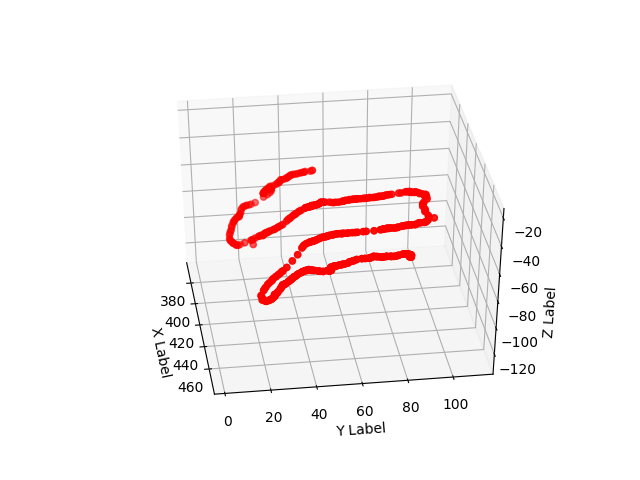

In [98]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')





ax.scatter(rs[:2500, 0], rs[:2500, 1], rs[:2500, 2], c='r', marker='o')
#ax.scatter(rs2[:2500, 0], rs2[:2500, 1], rs2[:2500, 2], c='g', marker='o')
set_axes_equal(ax)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [19]:
rs

array([[502.07598877,  25.75429916, -55.28030014],
       [502.07598877,  25.75429916, -55.28030014],
       [502.07598877,  25.75429916, -55.28030014],
       ...,
       [502.07598877,  25.75429916, -55.28030014],
       [502.07598877,  25.75429916, -55.28030014],
       [502.07598877,  25.75429916, -55.28030014]])

c:\users\hasti\anaconda3\envs\neuralnets\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


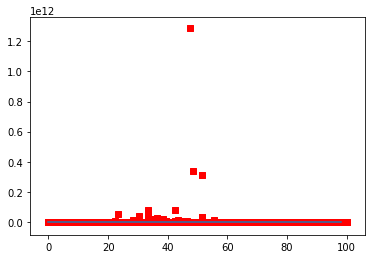

In [81]:
res = []
scat = []
for bet in np.linspace(0, 1, 100):
    
    scat = scat + [[]]
    averagelog = 0
    for __ in range(500):
        x = 25
        for _ in range(300):
            import random

            if random.random() > .6:
                x = x * ( 1 - bet)
            else:
                x = x * (1 + bet)
        averagelog += np.log(x)
        scat[-1] += [x]
    res = res + [averagelog / 500]
import matplotlib.pyplot as plt 
plt.plot(res)
for row in np.transpose(scat):
    plt.scatter(np.linspace(0, 100, 100), row, c="r", marker=",")
plt.show()

c:\users\hasti\anaconda3\envs\neuralnets\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\hasti\anaconda3\envs\neuralnets\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


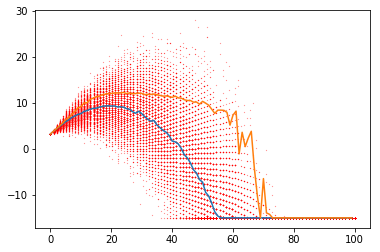

In [87]:
plt.plot(np.clip(res, -15,30))
for row in np.transpose(scat):
    plt.scatter(np.linspace(0, 100, 100), np.clip(np.log(row), -15,30), c="r", marker=".", s=.1)
    
plt.plot(np.clip(np.log(np.mean(np.clip(scat, 0, 1000000), axis=1)), -15, 30))
plt.show()